In [67]:
import torch
import torch.nn as nn
import tqdm

from models.kinematic_model.kinematic_model import KinematicModel
from models.timing_model.timing_model import TimingModel
from models.spatial_model.spatial_model import SpatialModel
import models.spatial_model.sm_config as sm_config
from models.robot_visualizer.robot_visualizer import RobotVisualizer
import task_specifications.tasks as tasks
import task_specifications.utils.operation_types as operation_types
import task_specifications.utils.operation_sequences as operation_sequences

In [2]:
km = KinematicModel()
tm = TimingModel()
sm = SpatialModel()
rv = RobotVisualizer()

In [3]:
def grid_to_joint_position(grid_position):
	x, y, z = grid_position
	return km.compute_inverse_kinematics(sm.compute_spatial_pose(x, y, z))

In [4]:
def generate_timed_task_matrix(task, initial_grid_position=(0, 0, 0)):
	x, y, z = initial_grid_position
	start_joint_position = grid_to_joint_position((x, y, z))
	task_matrix = []
	for operation in task:
		if isinstance(operation, operation_types.Move):
			x_t, y_t, z_t= operation.x, operation.y, operation.table_distance
			joint_position = grid_to_joint_position((x_t, y_t, z_t))
			time = tm.compute_duration_between_jps(start_joint_position, joint_position)
			task_matrix.append([*start_joint_position, *joint_position, time])
			start_joint_position = joint_position
		elif isinstance(operation, operation_types.Grip):
			task_matrix.append([*start_joint_position, *start_joint_position, 1.1])
		elif isinstance(operation, operation_types.MoveGripper):
			task_matrix.append([*start_joint_position, *start_joint_position, 1.1])
	return task_matrix    

In [5]:
def generate_trajectory(timed_task_matrix):
    trajectory = []
    for op in timed_task_matrix:
        start = op[:6]
        end = op[6:12]
        t = op[12]
        trajectory_segment = km.compute_trajectory(start.detach().numpy(), end.detach().numpy(), t.detach().numpy())
        trajectory.append(torch.tensor(trajectory_segment.q, dtype=torch.float32))
    return torch.cat(trajectory, dim=0)

In [6]:
def generate_random_task(max_blocks=8, x_min=-5, x_max=10, y_min=-9, y_max=9):
	task = []
	no_blocks = torch.randint(1, max_blocks, (1,)).item()
	for _ in range(no_blocks):
		x_origin = torch.randint(x_min, x_max, (1,)).item()
		y_origin = torch.randint(y_min, y_max, (1,)).item()
		x_target = torch.randint(x_min, x_max, (1,)).item()
		y_target = torch.randint(y_min, y_max, (1,)).item()

		task.extend(operation_sequences.move_and_grip(x_origin, y_origin))
		task.extend(operation_sequences.move_and_release(x_target, y_target))
	return task  

In [7]:
def generate_random_task(max_blocks=8, valid_regions=sm_config.VALID_REGIONS):
    """Generate a random task with positions constrained to valid regions."""
    task = []
    no_blocks = torch.randint(1, max_blocks, (1,)).item()

    for _ in range(no_blocks):
        # Select a region randomly for origin
        region_origin = valid_regions[torch.randint(0, len(valid_regions), (1,)).item()]
        x_origin, y_origin = generate_point_in_region(region_origin)

        # Select a region randomly for target
        region_target = valid_regions[torch.randint(0, len(valid_regions), (1,)).item()]
        x_target, y_target = generate_point_in_region(region_target)

        # Add operations for origin and target points
        task.extend(operation_sequences.move_and_grip(x_origin, y_origin))
        task.extend(operation_sequences.move_and_release(x_target, y_target))

    return task

def generate_point_in_region(region):
    """Generate a random point within a given region."""
    if isinstance(region, sm_config.Rectangle):
        x = torch.randint(region.xmin, region.xmax + 1, (1,)).item()
        y = torch.randint(region.ymin, region.ymax + 1, (1,)).item()
        return x, y
    elif isinstance(region, sm_config.Triangle):
        return generate_point_in_triangle_barycentric(region)

def generate_point_in_triangle_barycentric(triangle):
    """Generate a random point inside a triangle using barycentric coordinates."""
    v1, v2, v3 = triangle.v1, triangle.v2, triangle.v3

    # Generate two random numbers in [0, 1]
    u = torch.rand(1).item()
    v = torch.rand(1).item()

    # Ensure the point lies within the triangle by flipping coordinates if needed
    if u + v > 1:
        u, v = 1 - u, 1 - v

    # Compute the random point using the triangle's vertices and barycentric weights
    x = (1 - u - v) * v1[0] + u * v2[0] + v * v3[0]
    y = (1 - u - v) * v1[1] + u * v2[1] + v * v3[1]

    return int(round(x)), int(round(y))


# Data generation

In [13]:
def generate_tasks_and_trajectories(N):
	generated_tasks = []
	timed_task_matrices = []
	trajectories = []
	failed_tasks = 0

	while len(generated_tasks) < N:
		task = generate_random_task()
		try:
			timed_task_matrix = torch.tensor(generate_timed_task_matrix(task), dtype=torch.float32)
			trajectory = generate_trajectory(timed_task_matrix)
			generated_tasks.append(task)
			timed_task_matrices.append(timed_task_matrix)
			trajectories.append(trajectory)
		except Exception as e:
			failed_tasks += 1
			continue

	print(f"Failed tasks: {failed_tasks}")

	return generated_tasks, timed_task_matrices, trajectories


In [16]:
def generate_noisy_trajectories(timed_task_matrices, noise=0.04):
	# generate targets for each task with small noise
	target_timed_task_matrices = []
	for timed_task_matrix in timed_task_matrices:
		target_timed_task_matrix = timed_task_matrix.clone()
		for i in range(target_timed_task_matrix.size(0)):
			target_timed_task_matrix[i, 12] += torch.abs(torch.randn(1) * noise).item()
		target_timed_task_matrices.append(target_timed_task_matrix)

	# generate noisy trajectories for each task
	noisy_trajectories = [generate_trajectory(target_timed_task_matrix) for target_timed_task_matrix in target_timed_task_matrices]
	
	return noisy_trajectories

## Training data

In [24]:
N = 5000
generated_tasks, timed_task_matrices, trajectories = generate_tasks_and_trajectories(N)
noisy_trajectories = generate_noisy_trajectories(timed_task_matrices)

Failed tasks: 1219


In [25]:
# save to file
torch.save(generated_tasks, "dataset/generated_tasks.pt")
torch.save(timed_task_matrices, "dataset/timed_task_matrices.pt")
torch.save(trajectories, "dataset/trajectories.pt")
torch.save(noisy_trajectories, "dataset/noisy_trajectories.pt")

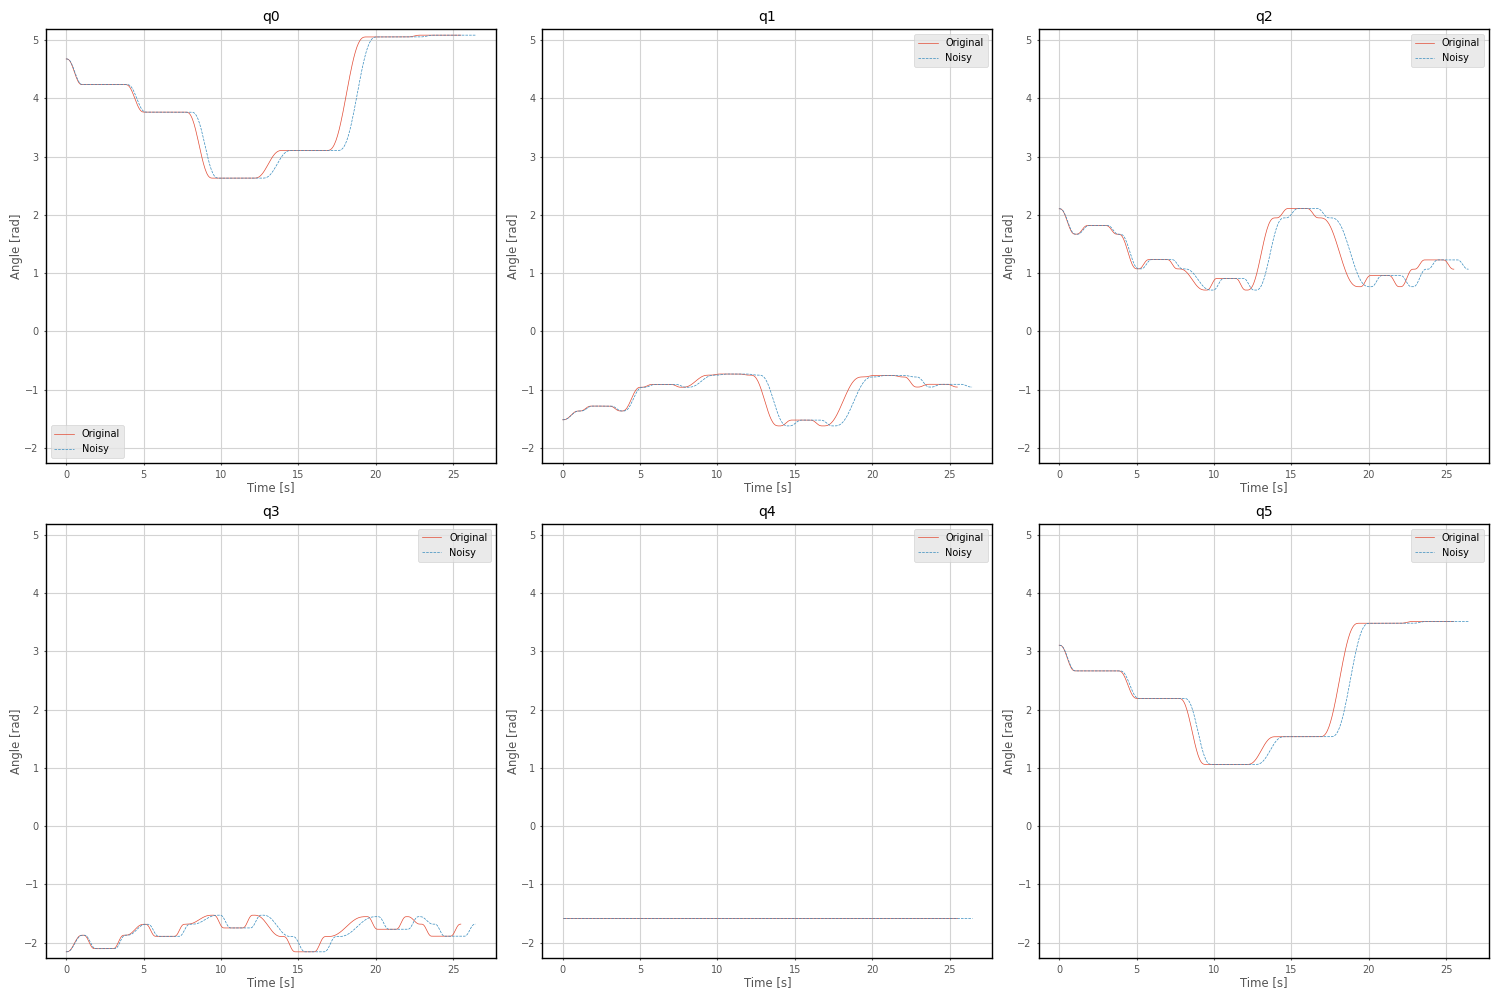

In [23]:
# show pairwise comparison of two trajectories
sample_trajectory = trajectories[100]
sample_noisy_trajectory = noisy_trajectories[100]
rv.plot_trajectory_2d([sample_trajectory.numpy(), sample_noisy_trajectory.numpy()], ["Original", "Noisy"])

## Test data

In [26]:
N = 500
test_generated_tasks, test_timed_task_matrices, test_trajectories = generate_tasks_and_trajectories(N)
test_noisy_trajectories = generate_noisy_trajectories(test_timed_task_matrices)

Failed tasks: 113


In [27]:
# save test data
torch.save(test_generated_tasks, "dataset/test_generated_tasks.pt")
torch.save(test_timed_task_matrices, "dataset/test_timed_task_matrices.pt")
torch.save(test_trajectories, "dataset/test_trajectories.pt")
torch.save(test_noisy_trajectories, "dataset/test_noisy_trajectories.pt")

## Load data from folder

In [8]:
trajectories = torch.load("dataset/trajectories.pt")
noisy_trajectories = torch.load("dataset/noisy_trajectories.pt")
test_trajectories = torch.load("dataset/test_trajectories.pt")
test_noisy_trajectories = torch.load("dataset/test_noisy_trajectories.pt")

C:\Users\Andreas\AppData\Local\Temp\ipykernel_1060\1794831558.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trajectories = torch.load("dataset/trajectories.pt")
C:\Use

# Setup neural network

In [9]:
class TimingOffsetModel(nn.Module):
	def __init__(self, 
			  input_size=6, 
			  hidden_size=128, 
			  num_layers=2,
			  dropout=0.5, 
			  bidirectional=False):
		super(TimingOffsetModel, self).__init__()

		# LSTM layer for sequence processing
		self.lstm = nn.LSTM(input_size, 
					  hidden_size, 
					  num_layers, 
					  batch_first=True,
					  bidirectional=bidirectional,
					  dropout=dropout)
		
		# Fully connected layers after the LSTM for the final output
		self.fc1 = nn.Linear(hidden_size, hidden_size * 2) if not bidirectional else nn.Linear(hidden_size * 2, hidden_size * 2)
		self.fc2 = nn.Linear(hidden_size * 2, hidden_size * 4)
		self.fc3 = nn.Linear(hidden_size * 4, input_size)  # Output is the same size as input (trajectory point)
		
		self.relu = nn.ReLU()
		
	def forward(self, x):
		# Get the last value of the tensor
		last_value = x[-1].unsqueeze(0)  # Shape (1, features)

		# Repeat the last value to create the padding
		padding = last_value.repeat(30, 1)  # Shape (pad_size, features)

		# Concatenate the original tensor with the padding
		x = torch.cat([x, padding], dim=0)  # Shape (seq_len + pad_size, features)

		# Pass through LSTM
		lstm_out, _ = self.lstm(x)  # Output from LSTM

		# Pass through fully connected layers for each time step
		x = self.fc1(lstm_out)
		x = self.relu(x)
		x = self.fc2(x)
		x = self.relu(x)
		x = self.fc3(x)

		return x

In [60]:
# instantiate model
model = TimingOffsetModel(hidden_size=256, dropout=0.4, num_layers=3)

# example forward pass
sample_trajectory = trajectories[0]
output = model(sample_trajectory)
print("input shape: ", sample_trajectory.shape)
print("output shape: ", output.shape)

input shape:  torch.Size([1209, 6])
output shape:  torch.Size([1239, 6])


In [70]:
def train_model(model, criterion, optimizer, inputs, outputs, num_epochs=1000):
	# Ensure both data and model are on the same device
	device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
	print(f"Training on {device}")
	model.to(device)
	inputs = [input.to(device) for input in inputs]
	outputs = [output.to(device) for output in outputs]
	
	for epoch in tqdm.tqdm(range(num_epochs), desc="Training epochs"):
		model.train()
		epoch_loss = 0

		for input, target in tqdm.tqdm(zip(inputs, outputs), desc="Training batches", leave=False):
			# Forward pass
			output = model(input)

			# Ensure trajectory lengths match
			with torch.no_grad():
				min_len = min(output.size(0), target.size(0))
				target_slices = target[:min_len]
			output_slices = output[:min_len]

			# Compute the loss
			loss = criterion(output_slices, target_slices)

			# Backward pass
			optimizer.zero_grad()
			loss.backward(retain_graph=True)  # Ensure the graph is retained if needed
			optimizer.step()

			epoch_loss += loss.item()

		# Output the loss for every 10 epochs
		if (epoch + 1) % 10 == 0:
			print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(inputs)}')

# criterion = nn.MSELoss(reduction='sum')
criterion = nn.HuberLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_model(model, criterion, optimizer, trajectories[0:10], noisy_trajectories[0:10], num_epochs=10)


Training on cpu


Training epochs:  10%|█         | 1/10 [00:03<00:32,  3.64s/it]

Epoch 1/10, Loss: 353.6803382873535


Training epochs:  20%|██        | 2/10 [00:06<00:24,  3.06s/it]

Epoch 2/10, Loss: 247.53599815368653


Training epochs:  30%|███       | 3/10 [00:08<00:19,  2.75s/it]

Epoch 3/10, Loss: 133.63090553283692


Training epochs:  40%|████      | 4/10 [00:11<00:16,  2.73s/it]

Epoch 4/10, Loss: 114.17211570739747


Training epochs:  50%|█████     | 5/10 [00:14<00:13,  2.78s/it]

Epoch 5/10, Loss: 87.31199169158936


Training epochs:  60%|██████    | 6/10 [00:16<00:10,  2.68s/it]

Epoch 6/10, Loss: 84.16795082092285


Training epochs:  70%|███████   | 7/10 [00:19<00:07,  2.55s/it]

Epoch 7/10, Loss: 82.85228824615479


Training epochs:  80%|████████  | 8/10 [00:21<00:05,  2.62s/it]

Epoch 8/10, Loss: 73.68650226593017


Training epochs:  90%|█████████ | 9/10 [00:25<00:02,  2.99s/it]

Epoch 9/10, Loss: 67.99322175979614


Training epochs: 100%|██████████| 10/10 [00:28<00:00,  2.80s/it]

Epoch 10/10, Loss: 62.7315276145935


# Model testing

In [12]:
# load pretrained model ('timing_offset_model.pth')
model = TimingOffsetModel(bidirectional=False)
model.load_state_dict(torch.load('timing_offset_model_unidirectional.pth', map_location=torch.device('cpu'), weights_only=True))

<All keys matched successfully>

In [71]:
# test model on test set
model.eval()
errors_uncorrected = []
errors_corrected = []
for noisy_trajectory, trajectory in zip(test_noisy_trajectories, test_trajectories):
	corrected_trajectory = model(noisy_trajectory)
	min_len = min(noisy_trajectory.size(0), trajectory.size(0))
	error_uncorrected = torch.nn.functional.mse_loss(noisy_trajectory[:min_len], trajectory[:min_len])
	error_corrected = torch.nn.functional.mse_loss(noisy_trajectory[:min_len], corrected_trajectory[:min_len])
	errors_uncorrected.append(error_uncorrected.item())
	errors_corrected.append(error_corrected.item())

In [72]:
print(f"Mean error uncorrected: {sum(errors_uncorrected) / len(errors_uncorrected)}")
print(f"Mean error corrected: {sum(errors_corrected) / len(errors_corrected)}")

Mean error uncorrected: 0.019204990571437975
Mean error corrected: 0.029016083247959613


Error uncorrected: 0.03840349614620209
Error corrected: 0.02982151508331299


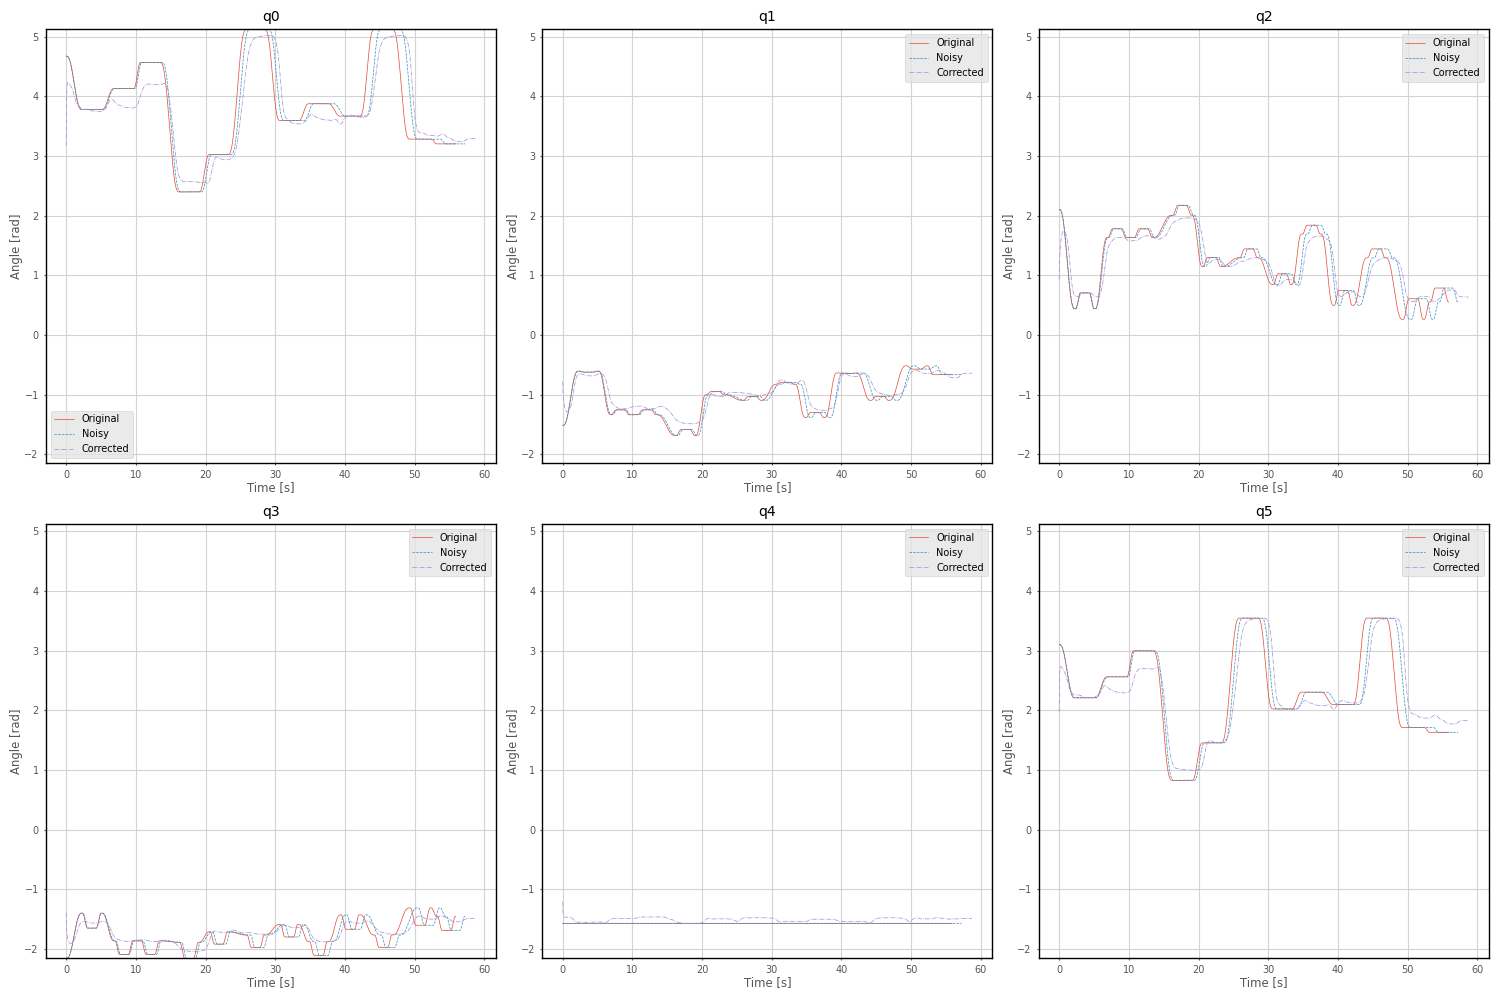

In [74]:
# show sample comparison
sample_noisy_trajectory = test_noisy_trajectories[0]
sample_trajectory = test_trajectories[0]
sample_corrected_trajectory = model(sample_noisy_trajectory)

min_len = min(sample_noisy_trajectory.size(0), sample_trajectory.size(0))
error_corrected = torch.nn.functional.mse_loss(sample_noisy_trajectory[:min_len], sample_corrected_trajectory[:min_len])
error_uncorrected = torch.nn.functional.mse_loss(sample_noisy_trajectory[:min_len], sample_trajectory[:min_len])
print(f"Error uncorrected: {error_uncorrected.item()}")
print(f"Error corrected: {error_corrected.item()}")

rv.plot_trajectory_2d([sample_trajectory.numpy(), sample_noisy_trajectory.numpy(), sample_corrected_trajectory.detach().numpy()], ["Original", "Noisy", "Corrected"])